# Algotrading prototyping notebook

### Important info

Alpha Vantage API key: DK3F3HB19R3IX4C3

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load the CSV into a DataFrame
eurusd = pd.read_csv('/Users/danieltompkins/Documents/Algotrading_project/Data/EURUSD_180525.csv', index_col=0, parse_dates=True)

# Optional: rename columns for simplicity
eurusd.columns = ['open', 'high', 'low', 'close']

# Optional: sort ascending (older dates first)
eurusd = eurusd.sort_index()

In [4]:
eurusd.head()

,open,high,low,close
date,,,,
2006-03-17,1.2182,1.2207,1.2139,1.2195
2006-03-20,1.2168,1.2196,1.2147,1.2165
2006-03-21,1.2154,1.2171,1.2074,1.2092
2006-03-22,1.2094,1.2114,1.2062,1.2074
2006-03-23,1.2075,1.2081,1.1953,1.1967


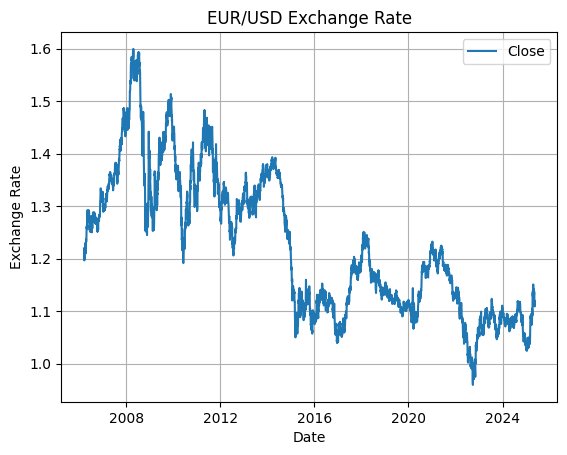

In [5]:
plt.plot(eurusd['close'], label='Close')
plt.title('EUR/USD Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid()
plt.show()

In [6]:
def generate_signals(df, window=20, num_std=2):
    """
    Generate trading signals based on a Bollinger Band mean reversion strategy.

    Parameters:
    ----------
    df : pandas.DataFrame
        DataFrame containing at least a 'close' column.
    window : int
        Rolling window size for SMA and standard deviation.
    num_std : float
        Number of standard deviations for upper and lower Bollinger Bands.

    Returns:
    -------
    df : pandas.DataFrame
        DataFrame with added columns: 'sma', 'upper_band', 'lower_band',
        'signal', 'exit', and 'position'.
    """
    df = df.copy()

    # Calculate Bollinger Bands
    df['sma'] = df['close'].rolling(window=window).mean()
    df['std'] = df['close'].rolling(window=window).std()
    df['upper_band'] = df['sma'] + num_std * df['std']
    df['lower_band'] = df['sma'] - num_std * df['std']

    # Initialize columns
    df['signal'] = 0
    df['exit'] = 0
    df['position'] = 0

    # Define entry conditions
    buy_entry = df['close'] < df['lower_band']
    sell_entry = df['close'] > df['upper_band']

    # Simulate trade state
    in_trade = 0
    position = []

    for i in range(len(df)):
        price = df['close'].iloc[i]
        sma = df['sma'].iloc[i]
        prev_price = df['close'].shift(1).iloc[i]
        prev_sma = df['sma'].shift(1).iloc[i]

        # ENTRY
        if in_trade == 0:
            if buy_entry.iloc[i]:
                df.at[df.index[i], 'signal'] = 1
                in_trade = 1
            elif sell_entry.iloc[i]:
                df.at[df.index[i], 'signal'] = -1
                in_trade = -1

        # EXIT
        elif in_trade == 1 and price > sma and prev_price <= prev_sma:
            df.at[df.index[i], 'exit'] = 1
            in_trade = 0
        elif in_trade == -1 and price < sma and prev_price >= prev_sma:
            df.at[df.index[i], 'exit'] = 1
            in_trade = 0

        position.append(in_trade)

    df['position'] = position

    return df


In [7]:
def plot_signals_over_period(df, start=None, end=None, rows=None):
    """
    Plot Bollinger Band trading signals (buy, sell, exit) over a selected time period.

    Parameters:
    ----------
    df : pandas.DataFrame
        Must contain 'close', 'sma', 'upper_band', 'lower_band', 'signal', and 'exit'.
    start : int, str, or datetime (optional)
        Starting index or date for the subset.
    end : int, str, or datetime (optional)
        Ending index or date for the subset.
    rows : int (optional)
        Number of rows from the end to include (overrides start/end if provided).
    """
    if rows is not None:
        subset = df.iloc[-rows:]
    elif start is not None and end is not None:
        subset = df.loc[start:end] if isinstance(start, str) or isinstance(start, pd.Timestamp) else df.iloc[start:end]
    else:
        raise ValueError("You must provide either `rows` or both `start` and `end`.")

    plt.figure(figsize=(14, 6))

    # Plot price + Bollinger Bands
    plt.plot(subset.index, subset['close'], label='Close Price', color='blue', linewidth=1.5)
    plt.plot(subset.index, subset['sma'], label='SMA', linestyle='--', color='orange')
    plt.plot(subset.index, subset['upper_band'], label='Upper Band', linestyle='--', color='green')
    plt.plot(subset.index, subset['lower_band'], label='Lower Band', linestyle='--', color='red')
    plt.fill_between(subset.index, subset['lower_band'], subset['upper_band'], color='grey', alpha=0.1)

    # Plot signals
    buy_signals = subset[subset['signal'] == 1]
    plt.scatter(buy_signals.index, buy_signals['close'], label='Buy', marker='^', color='green', s=100, zorder=3)

    sell_signals = subset[subset['signal'] == -1]
    plt.scatter(sell_signals.index, sell_signals['close'], label='Sell', marker='v', color='red', s=100, zorder=3)

    exit_signals = subset[subset['exit'] == 1]
    plt.scatter(exit_signals.index, exit_signals['close'], label='Exit', marker='o', color='gray', s=60, zorder=3)

    plt.title('EURUSD — Bollinger Band Strategy: Buy, Sell, Exit Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [8]:
def run_backtest(df, fee=0.0):
    """
    Run a vectorized backtest on a signal-enhanced DataFrame.

    Parameters:
    ----------
    df : pandas.DataFrame
        Must contain a 'close' column and a 'position' column (1, -1, 0).
    fee : float
        Transaction cost per position change (in decimal form, e.g., 0.0002 for 2bps).

    Returns:
    -------
    dict
        Contains updated DataFrame and performance metrics.
    """
    df = df.copy()
    
    # Step 1: Basic returns
    df['returns'] = df['close'].pct_change()

    # Step 2: Strategy returns
    df['strategy_returns'] = df['position'].shift(1) * df['returns']
    df['strategy_returns'] -= fee * df['position'].diff().abs().fillna(0)

    # Step 3: Cumulative returns
    df['cumulative_market'] = (1 + df['returns']).cumprod()
    df['cumulative_strategy'] = (1 + df['strategy_returns']).cumprod()

    # Step 4: Metrics
    strategy_returns = df['strategy_returns'].dropna()
    sharpe = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252) if strategy_returns.std() > 0 else 0
    max_drawdown = (df['cumulative_strategy'] / df['cumulative_strategy'].cummax() - 1).min()
    final_return = df['cumulative_strategy'].iloc[-1]

    return {
        'df': df,
        'sharpe': sharpe,
        'max_drawdown': max_drawdown,
        'final_return': final_return
    }



In [9]:
def plot_equity_curve(df):
    """
    Plot the equity curve for strategy and market.

    Parameters:
    ----------
    df : pandas.DataFrame
        Must contain 'cumulative_market' and 'cumulative_strategy' columns.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(df['cumulative_market'], label='Market', color='grey', linestyle='--')
    plt.plot(df['cumulative_strategy'], label='Strategy', color='blue')
    plt.title('EURUSD Bollinger Band Strategy vs Market')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [27]:
def compute_rolling_sharpe(df, window=252):
    """
    Compute rolling Sharpe ratio from strategy returns.

    Parameters
    ----------
    df : pd.DataFrame
        Must include 'strategy_returns' column.
    window : int
        Rolling window size (in trading days).

    Returns
    -------
    pd.Series
        Rolling Sharpe ratio (annualized).
    """
    rolling_mean = df['strategy_returns'].rolling(window).mean()
    rolling_std = df['strategy_returns'].rolling(window).std()
    rolling_sharpe = rolling_mean / rolling_std * np.sqrt(252)
    return rolling_sharpe

def plot_equity_with_rolling_sharpe(df, sharpe_window=252):
    """
    Plot cumulative strategy return and rolling Sharpe ratio on dual y-axes.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing 'strategy_returns' and 'cumulative_strategy'.
    sharpe_window : int
        Window size in days for rolling Sharpe calculation.
    """
    df = df.copy()
    df['rolling_sharpe'] = compute_rolling_sharpe(df, window=sharpe_window)

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot equity curve
    ax1.plot(df.index, df['cumulative_strategy'], label='Equity Curve', color='blue')
    ax1.set_ylabel("Cumulative Return", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Plot rolling Sharpe on secondary axis
    ax2 = ax1.twinx()
    ax2.plot(df.index, df['rolling_sharpe'], label=f'Rolling Sharpe ({sharpe_window}d)', color='green', alpha=0.7)
    ax2.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.9)
    ax2.set_ylabel("Rolling Sharpe Ratio", color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    # Add titles and layout
    plt.title(f"Equity Curve and Rolling Sharpe Ratio ({sharpe_window}-day)")
    fig.tight_layout()
    plt.grid(True)
    plt.show()


In [10]:
def generate_trade_log(df, window, num_std, performance=None, save_csv=False, filename="trade_log.csv"):
    """
    Generate a trade log from a DataFrame and append strategy metadata.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with 'signal', 'exit', 'position', and 'close'.
    window : int
        Window used for Bollinger Bands.
    num_std : float
        Std dev multiplier used for bands.
    performance : dict, optional
        Dictionary containing Sharpe, drawdown, final return, etc.
    save_csv : bool
        If True, saves the log to CSV.
    filename : str
        CSV filename to save (if save_csv=True).

    Returns
    -------
    trade_log : pd.DataFrame
        Trade log DataFrame with metadata as attributes.
    """
    in_trade = False
    entry_price = None
    entry_index = None
    direction = None
    trades = []

    for i in range(len(df)):
        row = df.iloc[i]

        if not in_trade and row['signal'] != 0:
            in_trade = True
            entry_price = row['close']
            entry_index = df.index[i]
            direction = row['signal']

        elif in_trade and row['exit'] == 1:
            exit_price = row['close']
            exit_index = df.index[i]
            trade_return = (exit_price - entry_price) / entry_price if direction == 1 else (entry_price - exit_price) / entry_price
            duration = (exit_index - entry_index).days if isinstance(exit_index, pd.Timestamp) else exit_index - entry_index

            trades.append({
                'Entry Date': entry_index,
                'Exit Date': exit_index,
                'Direction': 'Long' if direction == 1 else 'Short',
                'Entry Price': entry_price,
                'Exit Price': exit_price,
                'Return': trade_return,
                'Duration': duration
            })

            in_trade = False

    trade_log = pd.DataFrame(trades)

    # Add metadata as new columns (broadcasted)
    meta = {
        'window': window,
        'num_std': num_std,
        'Sharpe': performance.get('sharpe') if performance else None,
        'Max Drawdown': performance.get('max_drawdown') if performance else None,
        'Final Return': performance.get('final_return') if performance else None,
        'Win Rate': None  # To be calculated below
    }

    if not trade_log.empty:
        win_rate = (trade_log['Return'] > 0).mean()
        meta['Win Rate'] = round(win_rate, 4)
        for key, val in meta.items():
            trade_log[key] = val

    if save_csv:
        trade_log.to_csv(filename, index=False)
        print(f"Trade log saved to {filename}")

    return trade_log

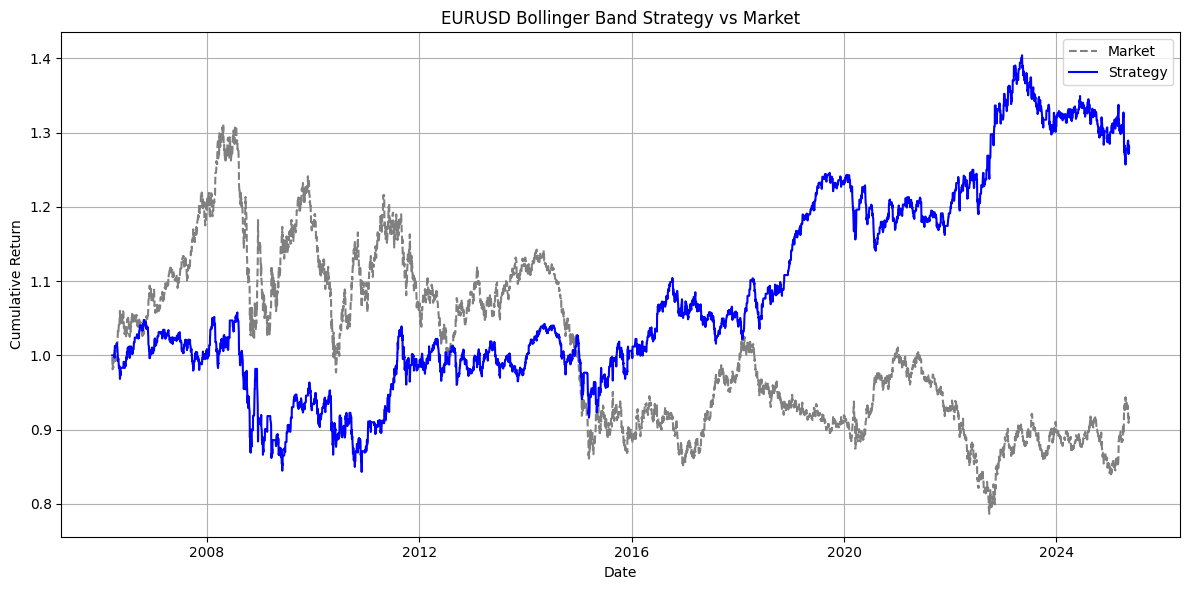

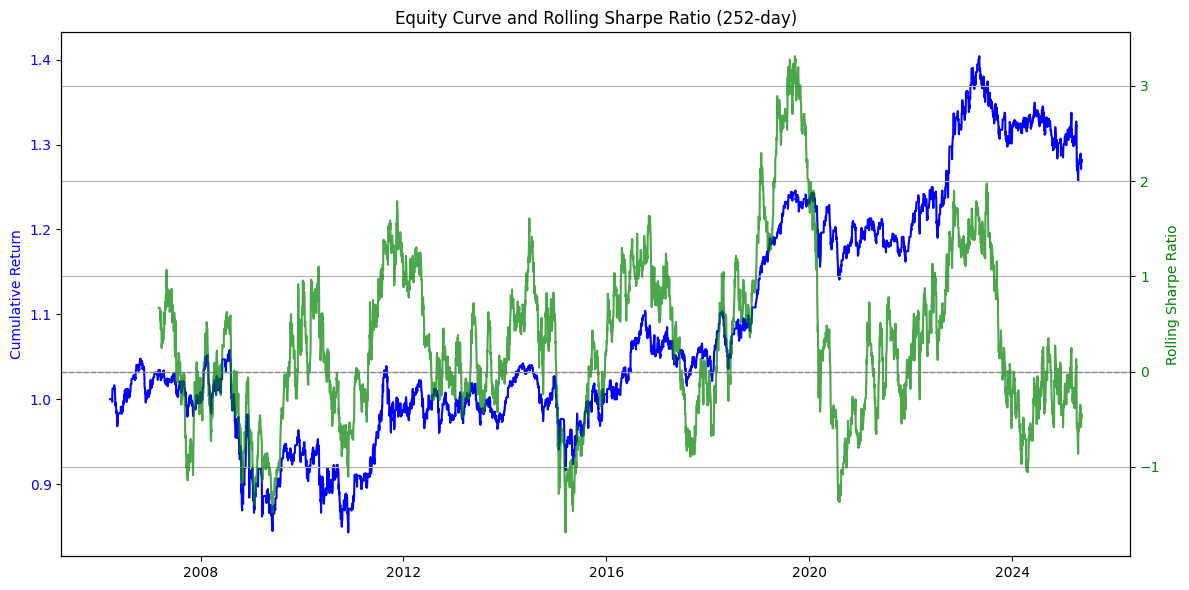

Sharpe Ratio: 0.21
Max Drawdown: -20.30%
Final Return: 1.28x


In [28]:
signals_df = generate_signals(eurusd, 10, 1.4)
results = run_backtest(signals_df)
plot_equity_curve(results['df'])
plot_equity_with_rolling_sharpe(results['df'], sharpe_window=252)

print(f"Sharpe Ratio: {results['sharpe']:.2f}")
print(f"Max Drawdown: {results['max_drawdown']:.2%}")
print(f"Final Return: {results['final_return']:.2f}x")

In [ ]:
trade_log = generate_trade_log(
    df=signals_df,
    window=10,
    num_std=1.4,
    performance=results,
    save_csv=True,
    filename='/Users/danieltompkins/Documents/Algotrading_project/Trade_logs/EURUSD_trade_log_10_1.4.csv'
)

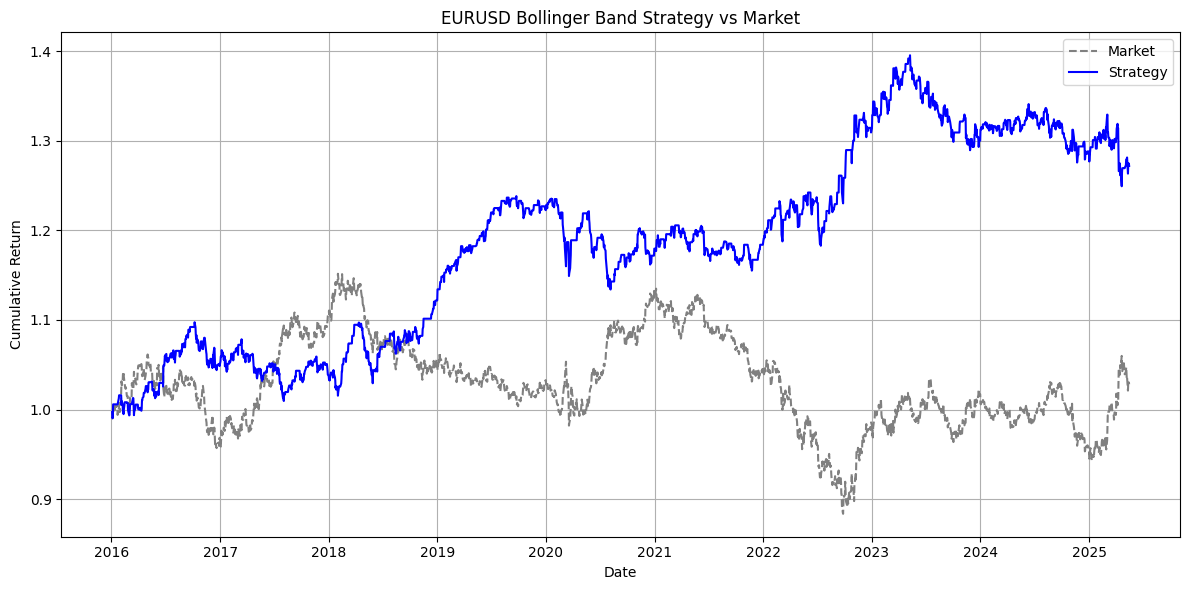

Post-2016 Sharpe: 0.45
Post-2016 Max Drawdown: -10.48%
Post-2016 Final Return: 1.27x


In [18]:
post_2016 = signals_df.loc["2016-01-01":]
results_post_2016 = run_backtest(post_2016)
plot_equity_curve(results_post_2016['df'])

print(f"Post-2016 Sharpe: {results_post_2016['sharpe']:.2f}")
print(f"Post-2016 Max Drawdown: {results_post_2016['max_drawdown']:.2%}")
print(f"Post-2016 Final Return: {results_post_2016['final_return']:.2f}x")

In [21]:
trade_log = pd.read_csv("/Users/danieltompkins/Documents/Algotrading_project/Trade_logs/EURUSD_trade_log_10_1.4.csv")
trade_log.head()

,Entry Date,Exit Date,Direction,Entry Price,Exit Price,Return,Duration,window,num_std,Sharpe,Max Drawdown,Final Return,Win Rate
0,2006-04-04,2006-04-07,Short,1.2258,1.2101,0.012808,3,10,1.4,0.20718,-0.203007,1.279949,0.659
1,2006-04-18,2006-05-17,Short,1.2361,1.2725,-0.029447,29,10,1.4,0.20718,-0.203007,1.279949,0.659
2,2006-06-02,2006-06-06,Short,1.2921,1.2817,0.008049,4,10,1.4,0.20718,-0.203007,1.279949,0.659
3,2006-06-08,2006-06-21,Long,1.2650,1.2664,0.001107,13,10,1.4,0.20718,-0.203007,1.279949,0.659
4,2006-06-23,2006-06-29,Long,1.2509,1.2667,0.012631,6,10,1.4,0.20718,-0.203007,1.279949,0.659


In [29]:
results['df'].head()

,open,high,low,close,sma,std,upper_band,lower_band,signal,exit,position,returns,strategy_returns,cumulative_market,cumulative_strategy
date,,,,,,,,,,,,,,,
2006-03-17,1.2182,1.2207,1.2139,1.2195,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN
2006-03-20,1.2168,1.2196,1.2147,1.2165,NaN,NaN,NaN,NaN,0,0,0,-0.002460,-0.0,0.997540,1.0
2006-03-21,1.2154,1.2171,1.2074,1.2092,NaN,NaN,NaN,NaN,0,0,0,-0.006001,-0.0,0.991554,1.0
2006-03-22,1.2094,1.2114,1.2062,1.2074,NaN,NaN,NaN,NaN,0,0,0,-0.001489,-0.0,0.990078,1.0
2006-03-23,1.2075,1.2081,1.1953,1.1967,NaN,NaN,NaN,NaN,0,0,0,-0.008862,-0.0,0.981304,1.0
